# Neural Network Learning

Initial imports

In [1]:
import os
import cv2
import numpy as np
import nnfs
import matplotlib.pyplot as plt
import pickle
import copy
nnfs.init()

Neural network layer class

In [2]:
class Layer_Dense:

    # Layer initialization
    def __init__(self, n_inputs, n_neurons,
                 weight_regularizer_l1=0, weight_regularizer_l2=0,
                 bias_regularizer_l1=0, bias_regularizer_l2=0):
        # Initialize weights and biases
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))
        # Set regularization strength
        self.weight_regularizer_l1 = weight_regularizer_l1
        self.weight_regularizer_l2 = weight_regularizer_l2
        self.bias_regularizer_l1 = bias_regularizer_l1
        self.bias_regularizer_l2 = bias_regularizer_l2

    # Forward pass
    def forward(self, inputs, training):
        # Remember input values
        self.inputs = inputs
        # Calculate output values from inputs, weights and biases
        self.output = np.dot(inputs, self.weights) + self.biases

    # Backward pass
    def backward(self, dvalues):
        # Gradients on parameters
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)


        # Gradients on regularization
        # L1 on weights
        if self.weight_regularizer_l1 > 0:
            dL1 = np.ones_like(self.weights)
            dL1[self.weights < 0] = -1
            self.dweights += self.weight_regularizer_l1 * dL1
        # L2 on weights
        if self.weight_regularizer_l2 > 0:
            self.dweights += 2 * self.weight_regularizer_l2 * \
                             self.weights
        # L1 on biases
        if self.bias_regularizer_l1 > 0:
            dL1 = np.ones_like(self.biases)
            dL1[self.biases < 0] = -1
            self.dbiases += self.bias_regularizer_l1 * dL1
        # L2 on biases
        if self.bias_regularizer_l2 > 0:
            self.dbiases += 2 * self.bias_regularizer_l2 * \
                            self.biases

        # Gradient on values
        self.dinputs = np.dot(dvalues, self.weights.T)

    # Retrieve layer parameters
    def get_parameters(self):
        return self.weights, self.biases
    
    # Set weights and biases in a layer instance
    def set_parameters(self, weights, biases):
        self.weights = weights
        self.biases = biases

Rectified Linear Unit (ReLU) activation function

In [3]:
class Activation_ReLU:

    # Forward pass
    def forward(self, inputs, training):
        # Remember input values
        self.inputs = inputs
        # Calculate output values from inputs
        self.output = np.maximum(0, inputs)

    # Backward pass
    def backward(self, dvalues):
        # Since we need to modify original variable,
        # let's make a copy of values first
        self.dinputs = dvalues.copy()

        # Zero gradient where input values were negative
        self.dinputs[self.inputs <= 0] = 0

    # Calculate predictions for outputs
    def predictions(self, outputs):
        return outputs

Softmax Activation function

In [4]:
class Activation_Softmax:

    # Forward pass
    def forward(self, inputs, training):
        # Remember input values
        self.inputs = inputs

        # Get unnormalized probabilities
        exp_values = np.exp(inputs - np.max(inputs, axis=1,
                                            keepdims=True))

        # Normalize them for each sample
        probabilities = exp_values / np.sum(exp_values, axis=1,
                                            keepdims=True)

        self.output = probabilities

    # Backward pass
    def backward(self, dvalues):

        # Create uninitialized array
        self.dinputs = np.empty_like(dvalues)

        # Enumerate outputs and gradients
        for index, (single_output, single_dvalues) in \
                enumerate(zip(self.output, dvalues)):
            # Flatten output array
            single_output = single_output.reshape(-1, 1)
            # Calculate Jacobian matrix of the output
            jacobian_matrix = np.diagflat(single_output) - \
                              np.dot(single_output, single_output.T)
            # Calculate sample-wise gradient
            # and add it to the array of sample gradients
            self.dinputs[index] = np.dot(jacobian_matrix,
                                         single_dvalues)

    # Calculate predictions for outputs
    def predictions(self, outputs):
        return np.argmax(outputs, axis=1)

Sigmoid Activation function

In [5]:
class Activation_Sigmoid:

    # Forward pass
    def forward(self, inputs, training):
        # Save input and calculate/save output
        # of the sigmoid function
        self.inputs = inputs
        self.output = 1 / (1 + np.exp(-inputs))

    # Backward pass
    def backward(self, dvalues):
        # Derivative - calculates from output of the sigmoid function
        self.dinputs = dvalues * (1 - self.output) * self.output

    # Calculate predictions for outputs
    def predictions(self, outputs):
        return (outputs > 0.5) * 1

Linear Activation function

In [6]:
class Activation_Linear:

    # Forward pass
    def forward(self, inputs, training):
        # Just remember values
        self.inputs = inputs
        self.output = inputs

    # Backward pass
    def backward(self, dvalues):
        # derivative is 1, 1 * dvalues = dvalues - the chain rule
        self.dinputs = dvalues.copy()

    # Calculate predictions for outputs
    def predictions(self, outputs):
        return outputs

Loss parent class

In [7]:
class Loss:

    # Regularization loss calculation
    def regularization_loss(self):

        # 0 by default
        regularization_loss = 0

        # Calculate regularization loss
        # iterate all trainable layers
        for layer in self.trainable_layers:

            # L1 regularization - weights
            # calculate only when factor greater than 0
            if layer.weight_regularizer_l1 > 0:
                regularization_loss += layer.weight_regularizer_l1 * \
                                       np.sum(np.abs(layer.weights))

            # L2 regularization - weights
            if layer.weight_regularizer_l2 > 0:
                regularization_loss += layer.weight_regularizer_l2 * \
                                       np.sum(layer.weights * \
                                              layer.weights)

            # L1 regularization - biases
            # calculate only when factor greater than 0
            if layer.bias_regularizer_l1 > 0:
                regularization_loss += layer.bias_regularizer_l1 * \
                                       np.sum(np.abs(layer.biases))

            # L2 regularization - biases
            if layer.bias_regularizer_l2 > 0:
                regularization_loss += layer.bias_regularizer_l2 * \
                                       np.sum(layer.biases * \
                                              layer.biases)

        return regularization_loss


    # Set/remember trainable layers
    def remember_trainable_layers(self, trainable_layers):
        self.trainable_layers = trainable_layers

    # Calculates the data and regularization losses
    # given model output and ground truth values
    def calculate(self, output, y, *, include_regularization=False):

        # Calculate sample losses
        sample_losses = self.forward(output, y)

        # Calculate mean loss
        data_loss = np.mean(sample_losses)

        # Add accumulated sum of losses and sample count
        self.accumulated_sum += np.sum(sample_losses)
        self.accumulated_count += len(sample_losses)

        # If just data loss - return it
        if not include_regularization:
            return data_loss

        # Return the data and regularization losses
        return data_loss, self.regularization_loss()

    # Calculates accumulated loss
    def calculate_accumulated(self, *, include_regularization=False):

        # Calculate mean loss
        data_loss = self.accumulated_sum / self.accumulated_count

        # If just data loss - return it
        if not include_regularization:
            return data_loss

        # Return the data and regularization losses
        return data_loss, self.regularization_loss()

    # Reset variables for accumulated loss
    def new_pass(self):
        self.accumulated_sum = 0
        self.accumulated_count = 0

Cross Entropy Loss function

In [8]:
class Loss_CategoricalCrossentropy(Loss):

    # Forward pass
    def forward(self, y_pred, y_true):

        # Number of samples in a batch
        samples = len(y_pred)

        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)

        # Probabilities for target values -
        # only if categorical labels
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[
                range(samples),
                y_true
            ]

        # Mask values - only for one-hot encoded labels
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(
                y_pred_clipped * y_true,
                axis=1
            )

        # Losses
        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods

    # Backward pass
    def backward(self, dvalues, y_true):

        # Number of samples
        samples = len(dvalues)
        # Number of labels in every sample
        # We'll use the first sample to count them
        labels = len(dvalues[0])

        # If labels are sparse, turn them into one-hot vector
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]

        # Calculate gradient
        self.dinputs = -y_true / dvalues
        # Normalize gradient
        self.dinputs = self.dinputs / samples

Combined softmax activation and cross entropy loss for faster backward step

In [9]:
class Activation_Softmax_Loss_CategoricalCrossentropy():

    # Backward pass
    def backward(self, dvalues, y_true):

        # Number of samples
        samples = len(dvalues)

        # If labels are one-hot encoded,
        # turn them into discrete values
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)

        # Copy so we can safely modify
        self.dinputs = dvalues.copy()
        # Calculate gradient
        self.dinputs[range(samples), y_true] -= 1
        # Normalize gradient
        self.dinputs = self.dinputs / samples

Binary Cross-Entropy Loss Class

In [10]:
class Loss_BinaryCrossentropy(Loss):

    # Forward pass
    def forward(self, y_pred, y_true):

        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)

        # Calculate sample-wise loss
        sample_losses = -(y_true * np.log(y_pred_clipped) +
                          (1 - y_true) * np.log(1 - y_pred_clipped))
        sample_losses = np.mean(sample_losses, axis=-1)

        # Return losses
        return sample_losses

    # Backward pass
    def backward(self, dvalues, y_true):

        # Number of samples
        samples = len(dvalues)
        # Number of outputs in every sample
        # We'll use the first sample to count them
        outputs = len(dvalues[0])

        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        clipped_dvalues = np.clip(dvalues, 1e-7, 1 - 1e-7)

        # Calculate gradient
        self.dinputs = -(y_true / clipped_dvalues -
                         (1 - y_true) / (1 - clipped_dvalues)) / outputs
        # Normalize gradient
        self.dinputs = self.dinputs / samples

Mean Squared Error Loss Class

In [11]:
class Loss_MeanSquaredError(Loss):  # L2 loss

    # Forward pass
    def forward(self, y_pred, y_true):

        # Calculate loss
        sample_losses = np.mean((y_true - y_pred)**2, axis=-1)

        # Return losses
        return sample_losses

    # Backward pass
    def backward(self, dvalues, y_true):

        # Number of samples
        samples = len(dvalues)
        # Number of outputs in every sample
        # We'll use the first sample to count them
        outputs = len(dvalues[0])

        # Gradient on values
        self.dinputs = -2 * (y_true - dvalues) / outputs
        # Normalize gradient
        self.dinputs = self.dinputs / samples

Mean Absolute Error Loss

In [12]:
class Loss_MeanAbsoluteError(Loss):  # L1 loss

    def forward(self, y_pred, y_true):

        # Calculate loss
        sample_losses = np.mean(np.abs(y_true - y_pred), axis=-1)

        # Return losses
        return sample_losses


    # Backward pass
    def backward(self, dvalues, y_true):

        # Number of samples
        samples = len(dvalues)
        # Number of outputs in every sample
        # We'll use the first sample to count them
        outputs = len(dvalues[0])

        # Calculate gradient
        self.dinputs = np.sign(y_true - dvalues) / outputs
        # Normalize gradient
        self.dinputs = self.dinputs / samples

Stochastic Gradient Descent with Momentum Optimizer Class

In [13]:
class Optimizer_SGD:

    # Initialize optimizer - set settings,
    # learning rate of 1. is default for this optimizer
    def __init__(self, learning_rate=1., decay=0., momentum=0.):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.momentum = momentum

    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                (1. / (1. + self.decay * self.iterations))

    # Update parameters
    def update_params(self, layer):

        # If we use momentum
        if self.momentum:

            # If layer does not contain momentum arrays, create them
            # filled with zeros
            if not hasattr(layer, 'weight_momentums'):
                layer.weight_momentums = np.zeros_like(layer.weights)

                # If there is no momentum array for weights
                # The array doesn't exist for biases yet either.
                layer.bias_momentums = np.zeros_like(layer.biases)

            # Build weight updates with momentum - take previous
            # updates multiplied by retain factor and update with
            # current gradients
            weight_updates = \
                self.momentum * layer.weight_momentums - \
                self.current_learning_rate * layer.dweights
            layer.weight_momentums = weight_updates

            # Build bias updates
            bias_updates = \
                self.momentum * layer.bias_momentums - \
                self.current_learning_rate * layer.dbiases
            layer.bias_momentums = bias_updates

        # Vanilla SGD updates (as before momentum update)
        else:
            weight_updates = -self.current_learning_rate * \
                             layer.dweights
            bias_updates = -self.current_learning_rate * \
                           layer.dbiases

        # Update weights and biases using either
        # vanilla or momentum updates
        layer.weights += weight_updates
        layer.biases += bias_updates

    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1

Adagrad Optimizer Class

In [14]:
class Optimizer_Adagrad:

    # Initialize optimizer - set settings
    def __init__(self, learning_rate=1., decay=0., epsilon=1e-7):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon


    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                (1. / (1. + self.decay * self.iterations))

    # Update parameters
    def update_params(self, layer):

        # If layer does not contain cache arrays,
        # create them filled with zeros
        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)

        # Update cache with squared current gradients
        layer.weight_cache += layer.dweights**2
        layer.bias_cache += layer.dbiases**2

        # Vanilla SGD parameter update + normalization
        # with square rooted cache
        layer.weights += -self.current_learning_rate * \
                         layer.dweights / \
                         (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.biases += -self.current_learning_rate * \
                        layer.dbiases / \
                        (np.sqrt(layer.bias_cache) + self.epsilon)

    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1

RMSProp Optimizer Class

In [15]:
class Optimizer_RMSprop:

    # Initialize optimizer - set settings
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7,
                 rho=0.9):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.rho = rho


    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                (1. / (1. + self.decay * self.iterations))

    # Update parameters
    def update_params(self, layer):

        # If layer does not contain cache arrays,
        # create them filled with zeros
        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)

        # Update cache with squared current gradients
        layer.weight_cache = self.rho * layer.weight_cache + \
            (1 - self.rho) * layer.dweights**2
        layer.bias_cache = self.rho * layer.bias_cache + \
            (1 - self.rho) * layer.dbiases**2

        # Vanilla SGD parameter update + normalization
        # with square rooted cache
        layer.weights += -self.current_learning_rate * \
                         layer.dweights / \
                         (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.biases += -self.current_learning_rate * \
                        layer.dbiases / \
                        (np.sqrt(layer.bias_cache) + self.epsilon)

    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1


Adam (Adaptive Momentum) Optimizer Class

In [16]:
class Optimizer_Adam:

    # Initialize optimizer - set settings
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7,
                 beta_1=0.9, beta_2=0.999):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.beta_1 = beta_1
        self.beta_2 = beta_2


    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                (1. / (1. + self.decay * self.iterations))

    # Update parameters
    def update_params(self, layer):

        # If layer does not contain cache arrays,
        # create them filled with zeros
        if not hasattr(layer, 'weight_cache'):
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_momentums = np.zeros_like(layer.biases)
            layer.bias_cache = np.zeros_like(layer.biases)

        # Update momentum  with current gradients
        layer.weight_momentums = self.beta_1 * \
                                 layer.weight_momentums + \
                                 (1 - self.beta_1) * layer.dweights
        layer.bias_momentums = self.beta_1 * \
                               layer.bias_momentums + \
                               (1 - self.beta_1) * layer.dbiases
        # Get corrected momentum
        # self.iteration is 0 at first pass
        # and we need to start with 1 here
        weight_momentums_corrected = layer.weight_momentums / \
            (1 - self.beta_1 ** (self.iterations + 1))
        bias_momentums_corrected = layer.bias_momentums / \
            (1 - self.beta_1 ** (self.iterations + 1))
        # Update cache with squared current gradients
        layer.weight_cache = self.beta_2 * layer.weight_cache + \
            (1 - self.beta_2) * layer.dweights**2
        layer.bias_cache = self.beta_2 * layer.bias_cache + \
            (1 - self.beta_2) * layer.dbiases**2
        # Get corrected cache
        weight_cache_corrected = layer.weight_cache / \
            (1 - self.beta_2 ** (self.iterations + 1))
        bias_cache_corrected = layer.bias_cache / \
            (1 - self.beta_2 ** (self.iterations + 1))

        # Vanilla SGD parameter update + normalization
        # with square rooted cache
        layer.weights += -self.current_learning_rate * \
                         weight_momentums_corrected / \
                         (np.sqrt(weight_cache_corrected) +
                             self.epsilon)

        layer.biases += -self.current_learning_rate * \
                         bias_momentums_corrected / \
                         (np.sqrt(bias_cache_corrected) +
                             self.epsilon)

    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1

Dropout Layer

In [17]:
class Layer_Dropout:

    # Init
    def __init__(self, rate):
        # Store rate, we invert it as for example for dropout
        # of 0.1 we need success rate of 0.9
        self.rate = 1 - rate

    # Forward pass
    def forward(self, inputs, training):
        # Save input values
        self.inputs = inputs

        # If not in the training mode - return values
        if not training:
            self.output = inputs.copy()
            return

        # Generate and save scaled mask
        self.binary_mask = np.random.binomial(1, self.rate,
                           size=inputs.shape) / self.rate
        # Apply mask to output values
        self.output = inputs * self.binary_mask


    # Backward pass
    def backward(self, dvalues):
        # Gradient on values
        self.dinputs = dvalues * self.binary_mask

Accuracy Calculation Parent Class

In [18]:
class Accuracy:

    # Calculates an accuracy
    # given predictions and ground truth values
    def calculate(self, predictions, y):

        # Get comparison results
        comparisons = self.compare(predictions, y)

        # Calculate an accuracy
        accuracy = np.mean(comparisons)

        # Add accumulated sum of matching values and sample count
        self.accumulated_sum += np.sum(comparisons)
        self.accumulated_count += len(comparisons)

        # Return accuracy
        return accuracy

    # Calculates accumulated accuracy
    def calculate_accumulated(self):

        # Calculate an accuracy
        accuracy = self.accumulated_sum / self.accumulated_count

        # Return the data and regularization losses
        return accuracy

    # Reset variables for accumulated accuracy
    def new_pass(self):
        self.accumulated_sum = 0
        self.accumulated_count = 0

Accuracy calculation for regression

In [19]:
class Accuracy_Regression(Accuracy):

    def __init__(self):
        # Create precision property
        self.precision = None

    # Calculates precision value
    # based on passed-in ground truth values
    def init(self, y, reinit=False):
        if self.precision is None or reinit:
            self.precision = np.std(y) / 250

    # Compares predictions to the ground truth values
    def compare(self, predictions, y):
        return np.absolute(predictions - y) < self.precision

Accuracy calculation for classification

In [20]:
class Accuracy_Categorical(Accuracy):

    def __init__(self, *, binary=False):
        # Binary mode?
        self.binary = binary

    # No initialization is needed
    def init(self, y):
        pass

    # Compares predictions to the ground truth values
    def compare(self, predictions, y):
        if not self.binary and len(y.shape) == 2:
            y = np.argmax(y, axis=1)
        return predictions == y

Input Layer Class

In [21]:
class Layer_Input:

    # Forward pass
    def forward(self, inputs, training):
        self.output = inputs

Neural Network Model Object Class

In [22]:
class Model:

    def __init__(self):
        # Create a list of network objects
        self.layers = []
        # Softmax classifier's output object
        self.softmax_classifier_output = None

    # Add objects to the model
    def add(self, layer):
        self.layers.append(layer)


    # Set loss, optimizer and accuracy
    def set(self, *, loss=None, optimizer=None, accuracy=None):
        if loss is not None:
            self.loss = loss

        if optimizer is not None:
            self.optimizer = optimizer
        
        if accuracy is not None:
            self.accuracy = accuracy

    # Finalize the model
    def finalize(self):

        # Create and set the input layer
        self.input_layer = Layer_Input()

        # Count all the objects
        layer_count = len(self.layers)

        # Initialize a list containing trainable layers:
        self.trainable_layers = []

        # Iterate the objects
        for i in range(layer_count):

            # If it's the first layer,
            # the previous layer object is the input layer
            if i == 0:
                self.layers[i].prev = self.input_layer
                self.layers[i].next = self.layers[i+1]

            # All layers except for the first and the last
            elif i < layer_count - 1:
                self.layers[i].prev = self.layers[i-1]
                self.layers[i].next = self.layers[i+1]

            # The last layer - the next object is the loss
            # Also let's save aside the reference to the last object
            # whose output is the model's output
            else:
                self.layers[i].prev = self.layers[i-1]
                self.layers[i].next = self.loss
                self.output_layer_activation = self.layers[i]

            # If layer contains an attribute called "weights",
            # it's a trainable layer -
            # add it to the list of trainable layers
            # We don't need to check for biases -
            # checking for weights is enough
            if hasattr(self.layers[i], 'weights'):
                self.trainable_layers.append(self.layers[i])


        # Update loss object with trainable layers
        self.loss.remember_trainable_layers(
            self.trainable_layers
        )

        # If output activation is Softmax and
        # loss function is Categorical Cross-Entropy
        # create an object of combined activation
        # and loss function containing
        # faster gradient calculation
        if isinstance(self.layers[-1], Activation_Softmax) and \
           isinstance(self.loss, Loss_CategoricalCrossentropy):
            # Create an object of combined activation
            # and loss functions
            self.softmax_classifier_output = \
                Activation_Softmax_Loss_CategoricalCrossentropy()
        
        # Update loss object with trainable layers
        if self.loss is not None:
            self.loss.remember_trainable_layers(self.trainable_layers)

    # Train the model
    def train(self, X, y, *, epochs=1, batch_size=None,
              print_every=1, validation_data=None):

        # Initialize accuracy object
        self.accuracy.init(y)

        # Default value if batch size is not being set
        train_steps = 1

        # If there is validation data passed,
        # set default number of steps for validation as well
        if validation_data is not None:
            validation_steps = 1

            # For better readability
            X_val, y_val = validation_data

        # Calculate number of steps
        if batch_size is not None:
            train_steps = len(X) // batch_size
            # Dividing rounds down. If there are some remaining
            # data but not a full batch, this won't include it
            # Add `1` to include this not full batch
            if train_steps * batch_size < len(X):
                train_steps += 1

            if validation_data is not None:
                validation_steps = len(X_val) // batch_size

                # Dividing rounds down. If there are some remaining
                # data but nor full batch, this won't include it
                # Add `1` to include this not full batch
                if validation_steps * batch_size < len(X_val):
                    validation_steps += 1

        # Main training loop
        for epoch in range(1, epochs+1):

            # Print epoch number
            print(f'epoch: {epoch}')

            # Reset accumulated values in loss and accuracy objects
            self.loss.new_pass()
            self.accuracy.new_pass()

            # Iterate over steps
            for step in range(train_steps):

                # If batch size is not set -
                # train using one step and full dataset
                if batch_size is None:
                    batch_X = X
                    batch_y = y

                # Otherwise slice a batch
                else:
                    batch_X = X[step*batch_size:(step+1)*batch_size]
                    batch_y = y[step*batch_size:(step+1)*batch_size]

                # Perform the forward pass
                output = self.forward(batch_X, training=True)

                # Calculate loss
                data_loss, regularization_loss = \
                    self.loss.calculate(output, batch_y,
                                        include_regularization=True)
                loss = data_loss + regularization_loss

                # Get predictions and calculate an accuracy
                predictions = self.output_layer_activation.predictions(
                                  output)
                accuracy = self.accuracy.calculate(predictions,
                                                   batch_y)

                # Perform backward pass
                self.backward(output, batch_y)


                # Optimize (update parameters)
                self.optimizer.pre_update_params()
                for layer in self.trainable_layers:
                    self.optimizer.update_params(layer)
                self.optimizer.post_update_params()

                # Print a summary
                if not step % print_every or step == train_steps - 1:
                    print(f'step: {step}, ' +
                          f'acc: {accuracy:.3f}, ' +
                          f'loss: {loss:.3f} (' +
                          f'data_loss: {data_loss:.3f}, ' +
                          f'reg_loss: {regularization_loss:.3f}), ' +
                          f'lr: {self.optimizer.current_learning_rate}')

            # Get and print epoch loss and accuracy
            epoch_data_loss, epoch_regularization_loss = \
                self.loss.calculate_accumulated(
                    include_regularization=True)
            epoch_loss = epoch_data_loss + epoch_regularization_loss
            epoch_accuracy = self.accuracy.calculate_accumulated()

            print(f'training, ' +
                  f'acc: {epoch_accuracy:.3f}, ' +
                  f'loss: {epoch_loss:.3f} (' +
                  f'data_loss: {epoch_data_loss:.3f}, ' +
                  f'reg_loss: {epoch_regularization_loss:.3f}), ' +
                  f'lr: {self.optimizer.current_learning_rate}')

            # If there is the validation data
            if validation_data is not None:

                # Evaluate the model:
                self.evaluate(*validation_data, batch_size = batch_size)

    # Performs forward pass
    def forward(self, X, training):

        # Call forward method on the input layer
        # this will set the output property that
        # the first layer in "prev" object is expecting
        self.input_layer.forward(X, training)

        # Call forward method of every object in a chain
        # Pass output of the previous object as a parameter
        for layer in self.layers:
            layer.forward(layer.prev.output, training)

        # "layer" is now the last object from the list,
        # return its output
        return layer.output


    # Performs backward pass
    def backward(self, output, y):

        # If softmax classifier
        if self.softmax_classifier_output is not None:
            # First call backward method
            # on the combined activation/loss
            # this will set dinputs property
            self.softmax_classifier_output.backward(output, y)

            # Since we'll not call backward method of the last layer
            # which is Softmax activation
            # as we used combined activation/loss
            # object, let's set dinputs in this object
            self.layers[-1].dinputs = \
                self.softmax_classifier_output.dinputs

            # Call backward method going through
            # all the objects but last
            # in reversed order passing dinputs as a parameter
            for layer in reversed(self.layers[:-1]):
                layer.backward(layer.next.dinputs)

            return

        # First call backward method on the loss
        # this will set dinputs property that the last
        # layer will try to access shortly
        self.loss.backward(output, y)

        # Call backward method going through all the objects
        # in reversed order passing dinputs as a parameter
        for layer in reversed(self.layers):
            layer.backward(layer.next.dinputs)

    # Evaluates the model using passed in dataset
    def evaluate(self, X_val, y_val, *, batch_size=None):

        # Default value if batch size is not being set
        validation_steps = 1

        # Calculate number of steps
        if batch_size is not None:
            validation_steps = len(X_val) // batch_size
            # Dividing rounds down. If there are some remaining data, but not a full batch, this won't include it
            # Add '1' to include this is not full batch

            if validation_steps * batch_size < len(X_val):
                validation_steps += 1
        
        # Reset accumulated values in loss
        # and accuracy objects
        self.loss.new_pass()
        self.accuracy.new_pass()

        # Iterate over steps
        for step in range(validation_steps):

            # If batch size is not set -
            # train using one step and full dataset
            if batch_size is None:
                batch_X = X_val
                batch_y = y_val


            # Otherwise slice a batch
            else:
                batch_X = X_val[
                    step*batch_size:(step+1)*batch_size
                ]
                batch_y = y_val[
                    step*batch_size:(step+1)*batch_size
                ]

            # Perform the forward pass
            output = self.forward(batch_X, training=False)

            # Calculate the loss
            self.loss.calculate(output, batch_y)

            # Get predictions and calculate an accuracy
            predictions = self.output_layer_activation.predictions(
                              output)
            self.accuracy.calculate(predictions, batch_y)

        # Get and print validation loss and accuracy
        validation_loss = self.loss.calculate_accumulated()
        validation_accuracy = self.accuracy.calculate_accumulated()

        # Print a summary
        print(f'validation, ' +
              f'acc: {validation_accuracy:.3f}, ' +
              f'loss: {validation_loss:.3f}')
        
    # Retrieves and returns parameters of trainable layers
    def get_parameters(self):
        parameters = []

        for layer in self.trainable_layers:
            parameters.append(layer.get_parameters())

        return parameters
    
    # Updates the model with new parameters
    def set_parameters(self, parameters):
        for parameter_set, layer in zip(parameters, self.trainable_layers):
            layer.set_parameters(*parameter_set)

    # Save the parameters to a file
    def save_parameters(self, path):

        with open(path, 'wb') as f:
            pickle.dump(self.get_parameters(), f)

    # Loads parameters from a file and updates a model instance with them
    def load_parameters(self, path):
        with open(path, 'rb') as f:
            self.set_parameters(pickle.load(f))

    # Saves the model
    def save(self, path):
        model = copy.deepcopy(self)

        # Reset accumulated values in loss and accuracy objects
        model.loss.new_pass()
        model.accuracy.new_pass()

        # Remove data from input layer and gradients from loss objects
        model.input_layer.__dict__.pop('output', None)
        model.loss.__dict__.pop('dinputs', None)

        # For each layer remove inputs, output, and dinputs properties
        for layer in model.layers:
            for property in ['inputs', 'output', 'dinputs', 'dweights', 'dbiases']:
                layer.__dict__.pop(property, None)

        with open(path, 'wb') as f:
            pickle.dump(model, f)

    # Loads and returns a model
    @staticmethod
    def load(path):
        with open(path, 'rb') as f:
            model = pickle.load(f)
        
        return model
    
    # Predicts on the samples
    def predict(self, X, *, batch_size=None):
        prediction_steps = 1

        if batch_size is not None:
            prediction_steps = len(X)

            if prediction_steps * batch_size < len(X):
                prediction_steps += 1
        
        output = []

        for step in range(prediction_steps):
            if batch_size is None:
                batch_X = X
            else:
                batch_X = X[step*batch_size:(step + 1)*batch_size]
            
            batch_output = self.forward(batch_X, training=False)

            output.append(batch_output)

        return np.vstack(output)

Load MNIST dataset

In [23]:
def load_mnist_dataset(dataset, path):

    # Scan all the directories and create a list of labels
    labels = os.listdir(os.path.join(path, dataset))

    # Create lists for samples and labels
    X = []
    y = []


    # For each label folder
    for label in labels:
        # And for each image in given folder
        for file in os.listdir(os.path.join(path, dataset, label)):
            # Read the image
            image = cv2.imread(
                        os.path.join(path, dataset, label, file),
                        cv2.IMREAD_UNCHANGED)

            # And append it and a label to the lists
            X.append(image)
            y.append(label)

    # Convert the data to proper numpy arrays and return
    return np.array(X), np.array(y).astype('uint8')

Create Dataset

In [24]:
def create_data_mnist(path):

    # Load both sets separately
    X, y = load_mnist_dataset('train', path)
    X_test, y_test = load_mnist_dataset('test', path)

    # And return all the data
    return X, y, X_test, y_test

<center>============ RUN ALL CELLS BEFORE THIS LINE FIRST ============</center>

Data retrieval and generation

In [25]:
X, y, X_test, y_test = create_data_mnist('fashion_mnist_images')

# Shuffle the training dataset
keys = np.array(range(X.shape[0]))
np.random.shuffle(keys)
X = X[keys]
y = y[keys]

# Scale and reshape samples
X = (X.reshape(X.shape[0], -1).astype(np.float32) - 127.5) / 127.5
X_test = (X_test.reshape(X_test.shape[0], -1).astype(np.float32) - 127.5) / 127.5

Model Training

In [26]:
# Instantiate the model
model = Model()


# Add layers
model.add(Layer_Dense(X.shape[1], 128))
model.add(Activation_ReLU())
model.add(Layer_Dense(128, 128))
model.add(Activation_ReLU())
model.add(Layer_Dense(128, 10))
model.add(Activation_Softmax())

# Set loss, optimizer and accuracy objects
model.set(
    loss=Loss_CategoricalCrossentropy(),
    optimizer=Optimizer_Adam(decay=1e-3),
    accuracy=Accuracy_Categorical()
)

# Finalize the model
model.finalize()

# Train the model
model.train(X, y, validation_data=(X_test, y_test), epochs=10, batch_size=128, print_every=100)

model.save('fashion_mnist.model')

epoch: 1
step: 0, acc: 0.031, loss: 2.303 (data_loss: 2.303, reg_loss: 0.000), lr: 0.001
step: 100, acc: 0.758, loss: 0.613 (data_loss: 0.613, reg_loss: 0.000), lr: 0.0009090909090909091
step: 200, acc: 0.820, loss: 0.458 (data_loss: 0.458, reg_loss: 0.000), lr: 0.0008333333333333334
step: 300, acc: 0.805, loss: 0.543 (data_loss: 0.543, reg_loss: 0.000), lr: 0.0007692307692307692
step: 400, acc: 0.828, loss: 0.456 (data_loss: 0.456, reg_loss: 0.000), lr: 0.0007142857142857143
step: 468, acc: 0.875, loss: 0.344 (data_loss: 0.344, reg_loss: 0.000), lr: 0.000681198910081744
training, acc: 0.755, loss: 0.658 (data_loss: 0.658, reg_loss: 0.000), lr: 0.000681198910081744
validation, acc: 0.822, loss: 0.490
epoch: 2
step: 0, acc: 0.859, loss: 0.404 (data_loss: 0.404, reg_loss: 0.000), lr: 0.0006807351940095304
step: 100, acc: 0.797, loss: 0.459 (data_loss: 0.459, reg_loss: 0.000), lr: 0.0006373486297004461
step: 200, acc: 0.875, loss: 0.330 (data_loss: 0.330, reg_loss: 0.000), lr: 0.000599161

Image preprocessing

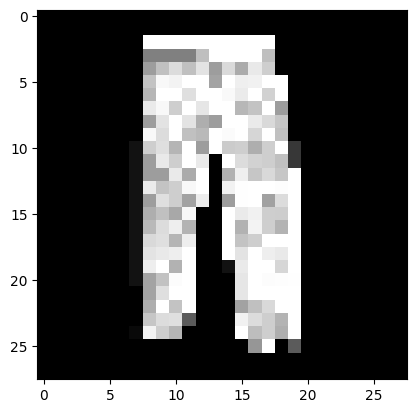

In [36]:
image_data = cv2.imread('test_images/pants.png', cv2.IMREAD_GRAYSCALE)

example_image = image_data

image_data = cv2.resize(image_data, (28, 28))
image_data = 255 - image_data
plt.imshow(image_data, cmap='gray') 
plt.show() 

image_data = (image_data.reshape(1, -1).astype(np.float32) - 127.5)/127.5 

Model loading and evaluation

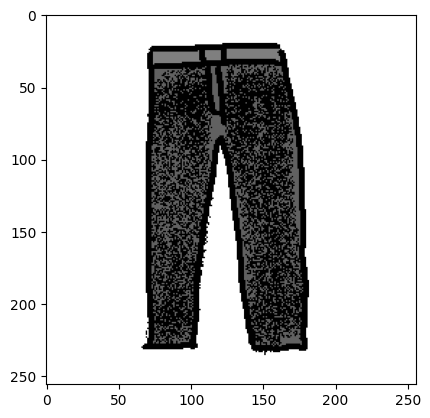

Prediction: Pants


In [37]:
model = Model.load('fashion_mnist.model')
plt.imshow(example_image, cmap="gray") 
plt.show() 

confidences = model.predict(image_data)
predictions = model.output_layer_activation.predictions(confidences)

fashion_mnist_labels = {
    0: 'T-shirt',
    1: 'Pants',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

for prediction in predictions:
    print("Prediction: " + fashion_mnist_labels[prediction])